In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed

from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import drugs as mgds_drugs
from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from mgds.data_modeling import constants as model_constants
from ml.api import trainer as ml_trainer

SEED = model_constants.SEED
RES_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_small'

def rpath(filename):
    return os.path.join(RES_DIR, filename)

2017-04-15 21:08:06,739:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')

2017-04-15 21:08:10,985:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-15 21:08:48,704:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-15 21:08:54,182:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107


In [4]:
#target_drugs = mgds_drugs.DEFAULT_DRUGS
target_drugs = mgds_drugs.GDSC_PAPER_DRUGS[:25] + mgds_drugs.DEFAULT_DRUGS
target_drugs

['SUNITINIB',
 'SB590885',
 'YM201636',
 'KIN001055',
 'GSK690693',
 'YM155',
 'GEMCITABINE',
 'JNKINHIBITORVIII',
 'LY317615',
 'AZD7762',
 'XMD132',
 'CGP60474',
 'PHA665752',
 'OLAPARIB',
 'NG25',
 'THZ21021',
 '681640',
 'AP24534',
 'IPA3',
 'BRYOSTATIN1',
 'BMS536924',
 'VX680',
 'PD0325901',
 'CISPLATIN',
 'CHIR99021',
 'NAVITOCLAX',
 'NUTLIN3A',
 'PLX4720',
 'SB590885',
 'AG014699',
 'PD0332991']

In [4]:
# import imp
# imp.reload(mkl)

In [5]:
X_drug, Y_drug = mkl.get_rx_modeling_data(
    drugs=target_drugs, genes=X_rppa.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)
# X_drug, Y_drug = mkl.get_rx_modeling_data(
#     drugs=target_drugs, genes=X_rppa.columns.tolist(), 
#     ge_src=src.GDSC_v2, site='BREAST'
# )
#X_drug, Y_drug = mkl.get_rx_modeling_data(drugs=target_drugs, genes=X_rppa.columns.tolist(), ge_src='agg')

2017-04-15 19:02:24,345:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-15 19:02:41,291:INFO:mgds.data_modeling.nbfn.mkl: Removing 4 drugs of 30 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


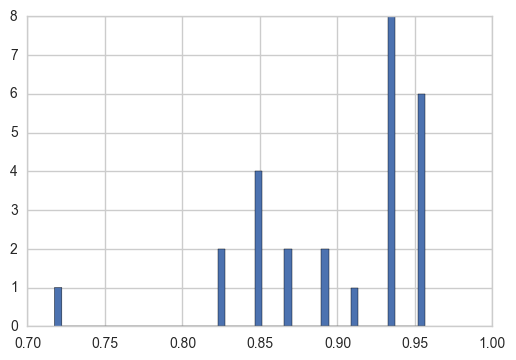

In [6]:
(Y_drug.notnull().sum(axis=0) / len(Y_drug)).hist(bins=50)

In [7]:
X_drug.shape, Y_drug.shape

((46, 13415), (46, 26))

In [8]:
X_rppa.shape, Y_rppa.shape

((403, 13415), (403, 169))

In [9]:
df_rppa.shape

(1105, 90637)

In [10]:
np.any(X_drug.isnull())

False

In [11]:
Y_drug.isnull().sum().sum() / Y_drug.values.ravel().shape[0]

0.099498327759197328

In [12]:
from sklearn.preprocessing import Imputer
Y_drug_imp = pd.DataFrame(Imputer(strategy='mean').fit_transform(Y_drug), index=Y_drug.index, columns=Y_drug.columns)

In [13]:
np.any(Y_drug_imp.isnull())

False

In [14]:
np.any(X_rppa.isnull())

False

In [15]:
np.any(Y_rppa.isnull())

False

# Modeling

In [16]:
# import imp
# imp.reload(mklmodel)
# imp.reload(ed_models)

In [17]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [16]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def get_mkl_model(i):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(X_rppa.values, Y_rppa.values, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=100, random_state=SEED, 
        fail_if_not_converged=False, max_steps=2500,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4cv/{}'.format(i))
    return est
    
    
ests = {
    'lasso': lambda i: Pipeline([
        ('scale', StandardScaler()),
        #('est', MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25)))
        ('est', MultiOutputRegressor(LassoCV(random_state=SEED, alphas=[1., .5, .25, .1, .08, .06])))
    ]),
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 10))))
    ]),
    'pcareg': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]),
    'rf': lambda i: RandomForestRegressor(random_state=SEED),
    'svr': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(0, 5, 10)})))
    ]),
    'mkl': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

cv = KFold(n_splits=5, random_state=SEED, shuffle=True).split(X_drug)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'mkl':
        est = est.fit(X_train.values, Y_train.values)
#         if fold == -1:
#             print('Extracting tensors from refit model')
#             est.all_tensors_ = est.get_tensor('')
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [17]:
! rm -rf /tmp/mkl4cv/*
train_res = cv_trainer.train_regressors(X_drug, Y_drug_imp, ests, cv)

2017-04-15 19:02:58,059:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 26), dim(Y_test) = (10, 26)
2017-04-15 19:02:58,072:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 26), dim(Y_test) = (10, 26)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might w

Beginning model refitting


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-04-15 19:12:08,849:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 0 ==> dim(X_train) = (46, 13415), dim(X_test) = (46, 13415), dim(Y_train) =

In [18]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
AU565             BREAST             3.295951     1  baseline   2.715146   
BT20              BREAST             2.167905     1  baseline   2.715146   
EFM19             BREAST             2.547300     1  baseline   2.715146   
HCC1500           BREAST             3.080150     1  baseline   2.715146   
HCC1569           BREAST             0.797343     1  baseline   2.715146   

                                       Task  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS          
AU565             BREAST             681640  
BT20              BREAST             681640  
EFM19             BREAST             681640  
HCC1500           BREAST             681640  
HCC1569           BREAST             681640

In [19]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']

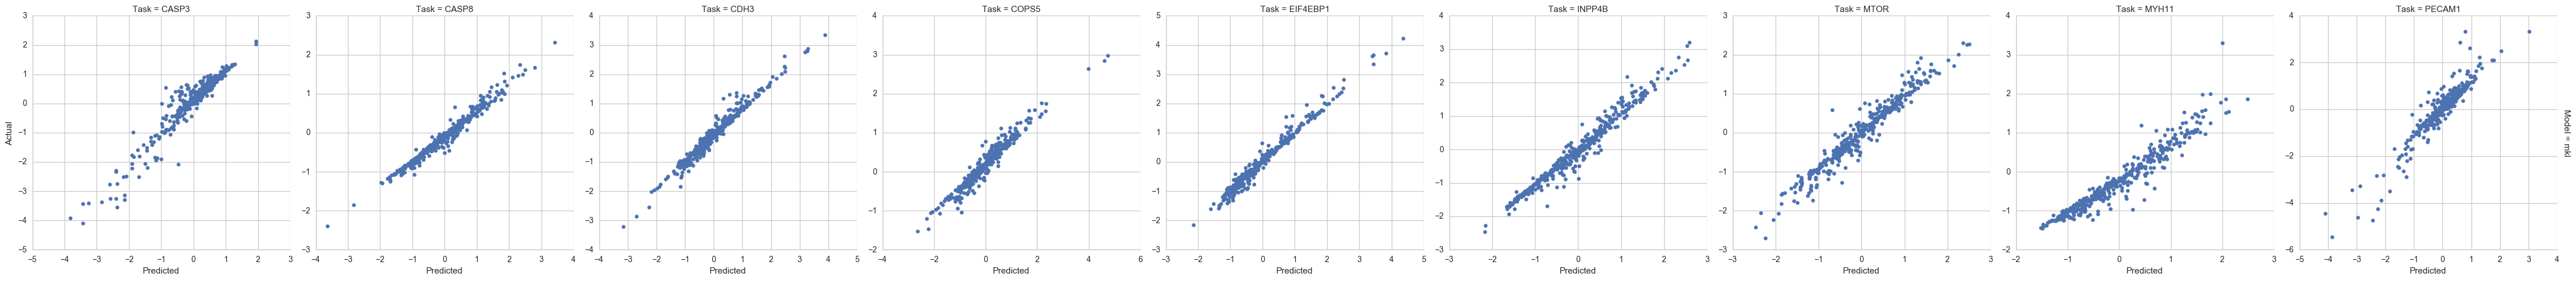

In [20]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Y_rppa.index, columns=Y_rppa.columns)
d_pred_train = mkl.stack_predictions(Yp, Y_rppa).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10).values
predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)

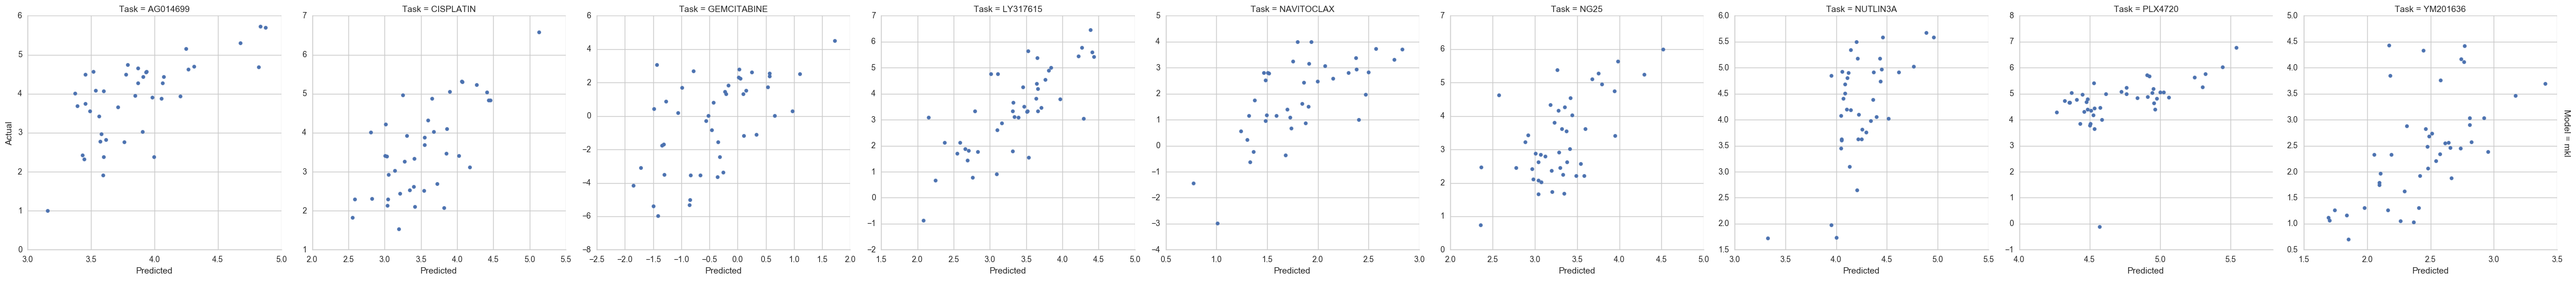

In [39]:
# Predictions on drug training data
Yp = est.clf.predict(X_drug.values)
d_pred_train = mkl.stack_predictions(Yp, Y_drug).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=1).values
predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)

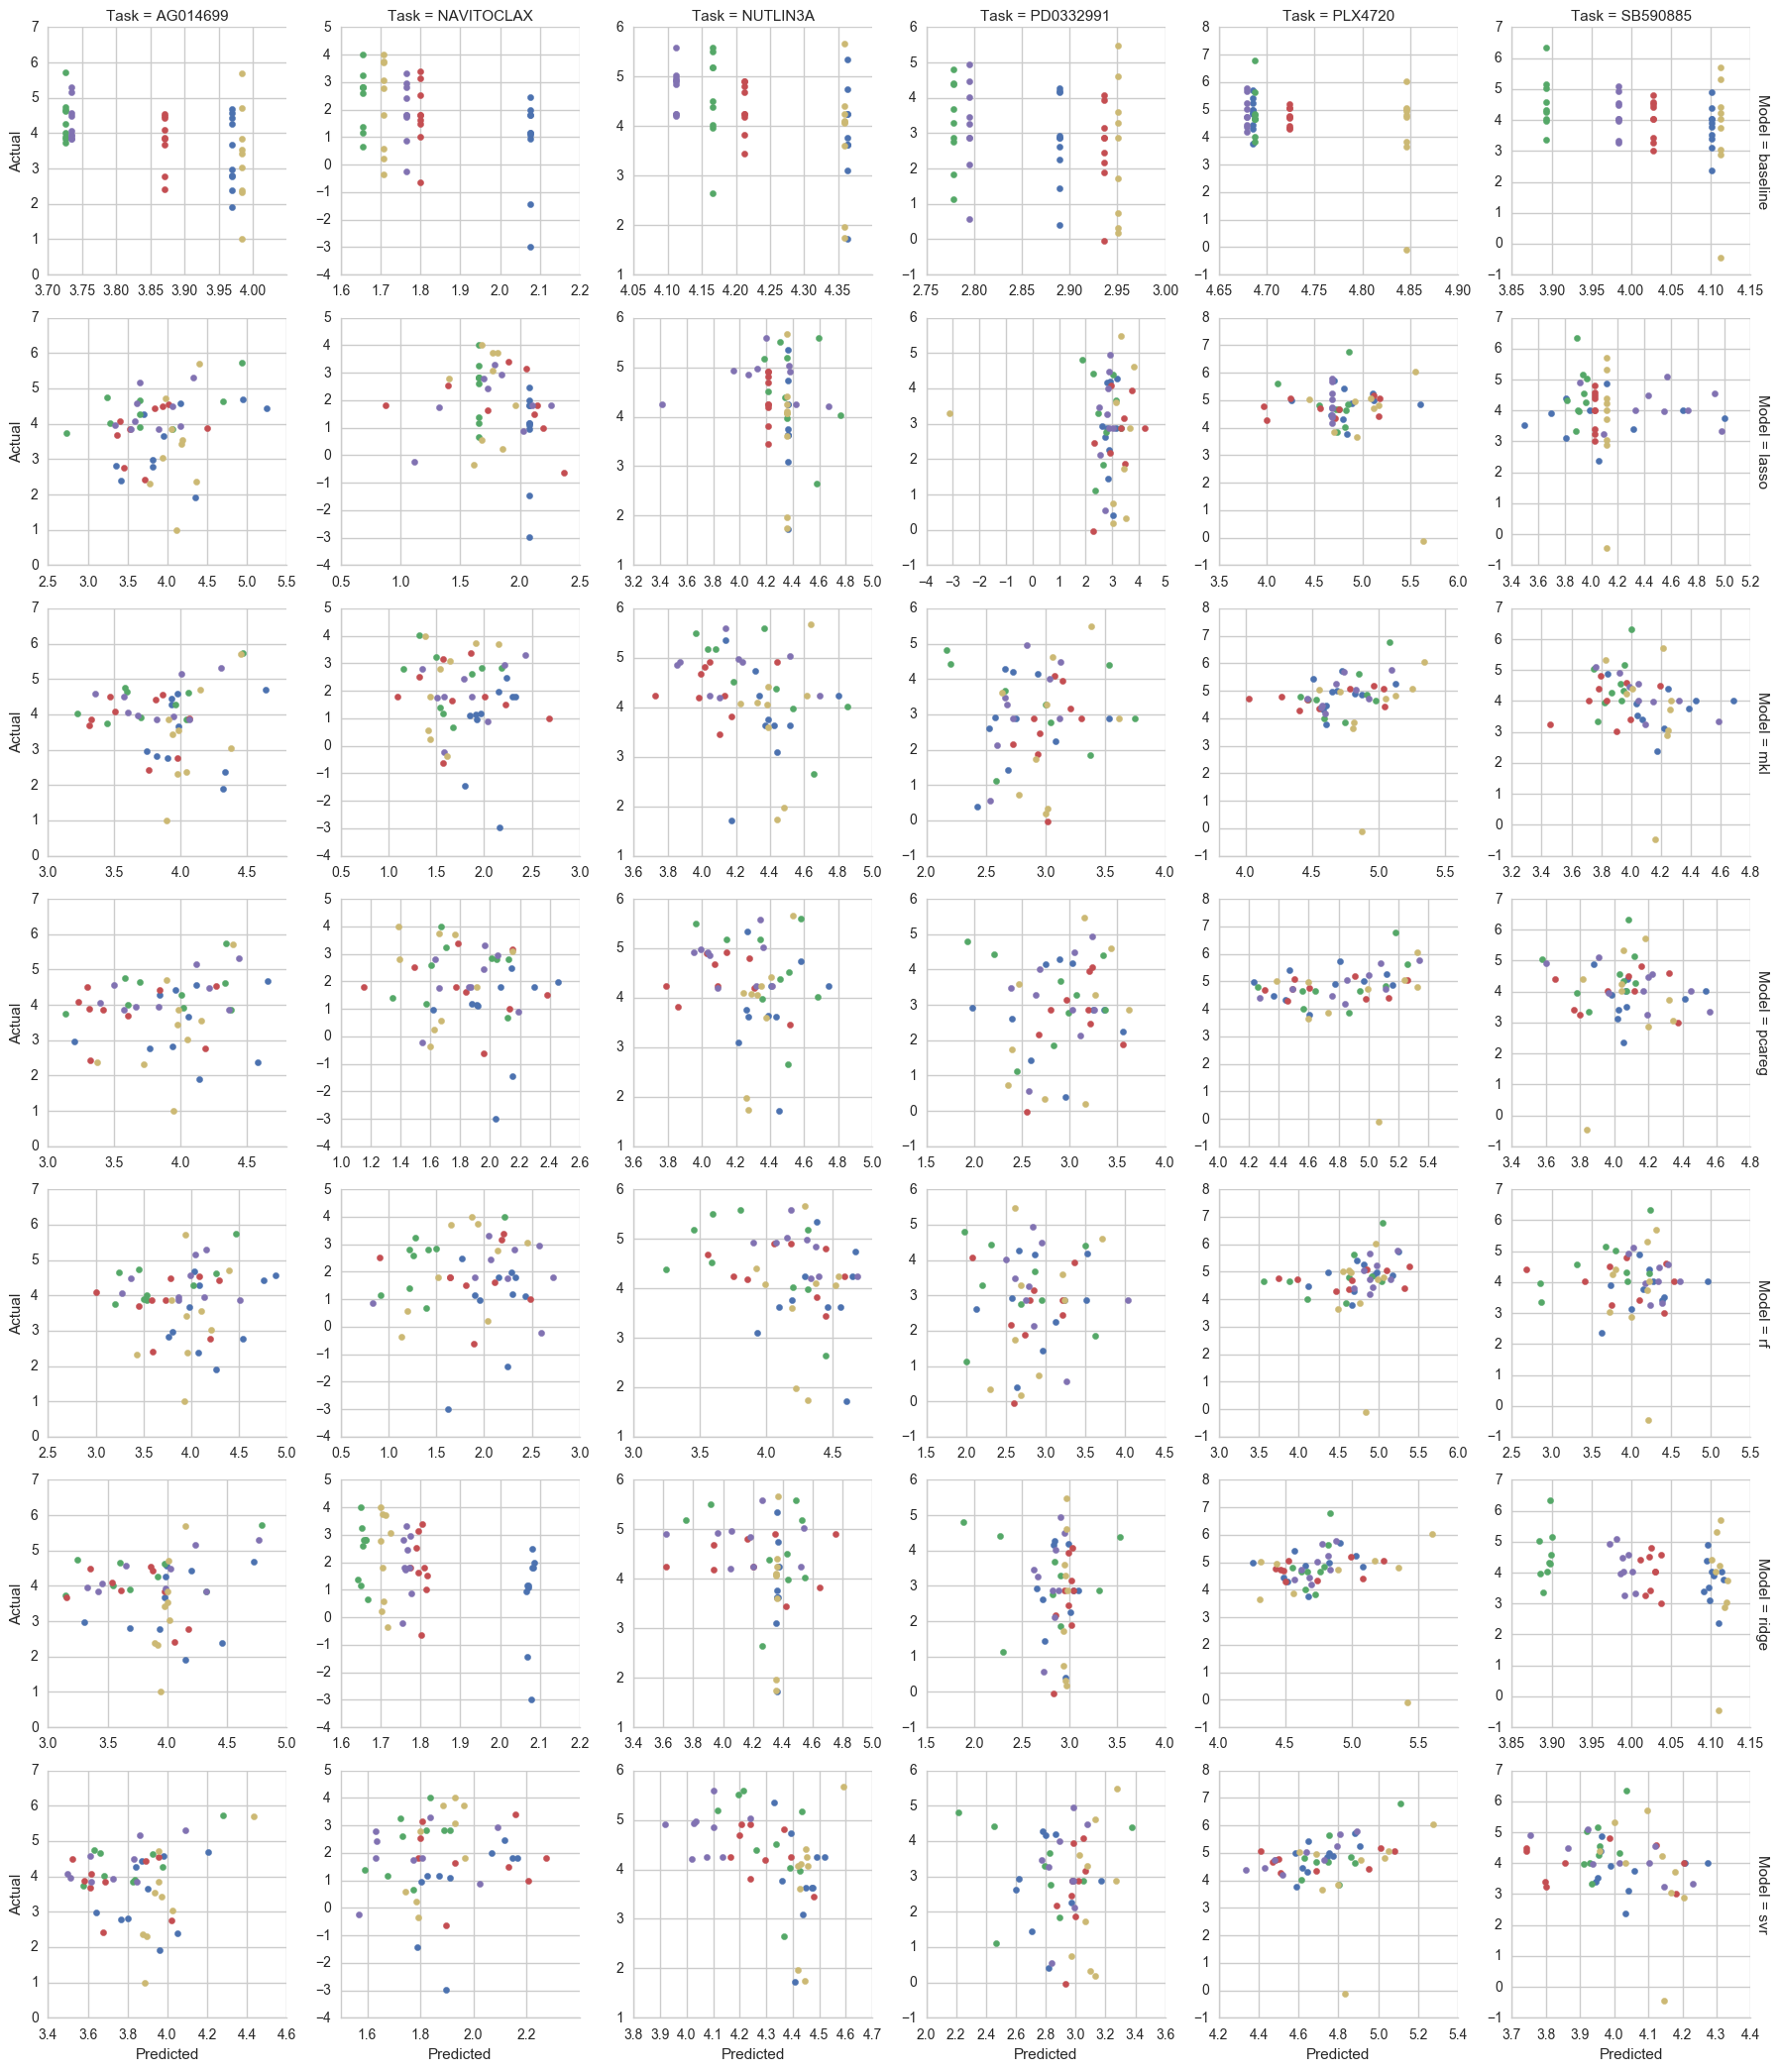

In [22]:
#tasks = d_pred_melt['Task'].sample(n=10).values
tasks = mgds_drugs.DEFAULT_DRUGS
predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)

In [152]:
import imp
imp.reload(performance)

<module 'ml.api.results.performance' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/performance.py'>

In [23]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold    Task      Metric     Value
0  baseline  All  681640     pearson -0.337131
1  baseline  All  681640   pearson_p  0.021956
2  baseline  All  681640    r2_score -0.069474
3  baseline  All  681640    spearman -0.260028
4  baseline  All  681640  spearman_p  0.080947

In [170]:
imp.reload(performance)

<module 'ml.api.results.performance' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/performance.py'>

In [38]:
from py_utils import plotly_utils
figs = performance.visualize(d_score, separate_by='Metric', kind='scatter', auto_plot=False)
for metric in figs:
    filename = rpath('perf_scatter_{}.html'.format(metric))
    plty.offline.plt(figs[metric], filename=filename)
    print(filename)
[plotly_utils.iplot(fig) for fig in figs.values()]

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_scatter_spearman_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_scatter_r2_score.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_scatter_pearson.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_scatter_spearman.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_scatter_pearson_p.html


[None, None, None, None, None]

In [32]:
def plot_performance_metric(d_score, metric=None):
    title = 'Performance Scores'
    if metric is not None:
        d_score = d_score[d_score['Metric'] == metric]
        title = metric
    
    fig = performance.visualize(d_score, separate_by=None, auto_plot=False, layout_kwargs={'title': title})['All']
    filename = rpath('perf_box_{}.html'.format(metric if metric else 'all'))
    plty.offline.plt(fig, filename=filename)
    print(filename)
    plty.offline.iplt(fig)

In [33]:
plot_performance_metric(d_score)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_box_all.html


In [34]:
plot_performance_metric(d_score, metric='pearson')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_box_pearson.html


In [35]:
plot_performance_metric(d_score, metric='spearman')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_box_spearman.html


In [36]:
plot_performance_metric(d_score, metric='pearson_p')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/perf_box_pearson_p.html


# Drug Selection

Based on performance above:

In [46]:
d_score.head()

Model Fold    Task      Metric     Value
0  baseline  All  681640     pearson -0.337131
1  baseline  All  681640   pearson_p  0.021956
2  baseline  All  681640    r2_score -0.069474
3  baseline  All  681640    spearman -0.260028
4  baseline  All  681640  spearman_p  0.080947

In [89]:
def get_most_predictable_tasks(metric):
    assert np.all(d_score['Fold'] == 'All')
    d_top_perf = d_score.set_index(['Model', 'Task', 'Metric'])['Value'].unstack()
    d_top_perf = d_top_perf[(d_top_perf[metric] >= 0) & (d_top_perf['{}_p'.format(metric)] <= .1)]
    return d_top_perf
d_top_perf = get_most_predictable_tasks('spearman')
d_top_perf

Metric             pearson  pearson_p  r2_score  spearman  spearman_p
Model  Task                                                          
lasso  AP24534    0.259062   0.082122 -0.093000  0.346803    0.018216
       AZD7762    0.328027   0.026045 -0.003887  0.430561    0.002818
       GSK690693  0.317855   0.031347  0.068612  0.387529    0.007794
       XMD132     0.380213   0.009148  0.130399  0.380374    0.009117
mkl    AP24534    0.320631   0.029819  0.101006  0.308580    0.036932
       AZD7762    0.590776   0.000015  0.342208  0.549097    0.000078
       CHIR99021  0.229931   0.124238  0.034561  0.306416    0.038347
       CISPLATIN  0.351636   0.016559  0.122802  0.290045    0.050547
       GSK690693  0.265865   0.074123  0.064955  0.347684    0.017904
       OLAPARIB   0.408401   0.004837  0.165043  0.371182    0.011097
       PD0325901  0.282550   0.057096  0.078999  0.375425    0.010141
       PLX4720    0.192215   0.200630  0.028213  0.367545    0.011976
       XMD132     0.370201   0.011328  0.131410  0.410720    0.004579
pcareg AP24534    0.429705   0.002880  0.178095  0.405539    0.005173
       AZD7762    0.616480   0.000005  0.376909  0.613922    0.000006
       CHIR99021  0.401222   0.005719  0.152909  0.418260    0.003821
       CISPLATIN  0.450319   0.001688  0.202104  0.406298    0.005082
       GSK690693  0.373840   0.010489  0.138877  0.412077    0.004433
       OLAPARIB   0.434226   0.002569  0.180884  0.382166    0.008768
       PD0325901  0.331026   0.024633  0.103029  0.429666    0.002883
       PLX4720    0.182266   0.225378 -0.002159  0.385555    0.008141
       XMD132     0.358544   0.014413  0.126218  0.371615    0.010996
rf     AP24534    0.356958   0.014883  0.119383  0.406402    0.005070
       AZD7762    0.325197   0.027439  0.083948  0.318630    0.030914
       CHIR99021  0.206170   0.169239  0.003282  0.278408    0.060996
       LY317615   0.270462   0.069075  0.066568  0.291406    0.049426
       OLAPARIB   0.244460   0.101562  0.028487  0.262080    0.078494
       PLX4720    0.184423   0.219841 -0.025123  0.404058    0.005355
ridge  AP24534    0.353655   0.015905  0.098864  0.356196    0.015114
       AZD7762    0.538363   0.000114  0.288538  0.544837    0.000090
       CHIR99021  0.413211   0.004315  0.170276  0.475077    0.000849
       CISPLATIN  0.382547   0.008696  0.144715  0.336657    0.022154
       GSK690693  0.364456   0.012769  0.131917  0.412817    0.004356
       KIN001055  0.314146   0.033490  0.092383  0.278269    0.061131
       OLAPARIB   0.511237   0.000283  0.254077  0.450046    0.001700
       PD0325901  0.287261   0.052905  0.068930  0.399148    0.005998
       PLX4720   -0.023422   0.877210 -0.110913  0.336582    0.022186
       XMD132     0.335769   0.022531  0.109998  0.328440    0.025847
svr    AP24534    0.353260   0.016032  0.114042  0.383704    0.008478
       AZD7762    0.584286   0.000020  0.272501  0.565458    0.000042
       CHIR99021  0.369253   0.011556  0.124140  0.451635    0.001629
       CISPLATIN  0.404133   0.005346  0.139208  0.306899    0.038027
       GSK690693  0.239203   0.109366  0.048995  0.259977    0.081009
       OLAPARIB   0.522016   0.000199  0.205729  0.385128    0.008218
       PD0325901  0.331032   0.024630  0.094905  0.408415    0.004835
       PLX4720    0.250980   0.092485  0.061597  0.391229    0.007177

In [90]:
d_top_perf.reset_index().groupby('Task')['Model'].unique()

Task
AP24534      [lasso, mkl, pcareg, rf, ridge, svr]
AZD7762      [lasso, mkl, pcareg, rf, ridge, svr]
CHIR99021           [mkl, pcareg, rf, ridge, svr]
CISPLATIN               [mkl, pcareg, ridge, svr]
GSK690693        [lasso, mkl, pcareg, ridge, svr]
KIN001055                                 [ridge]
LY317615                                     [rf]
OLAPARIB            [mkl, pcareg, rf, ridge, svr]
PD0325901               [mkl, pcareg, ridge, svr]
PLX4720             [mkl, pcareg, rf, ridge, svr]
XMD132                [lasso, mkl, pcareg, ridge]
Name: Model, dtype: object

In [91]:
top_drugs = d_top_perf.loc['mkl'].index.get_level_values('Task')
top_drugs

Index(['AP24534', 'AZD7762', 'CHIR99021', 'CISPLATIN', 'GSK690693', 'OLAPARIB',
       'PD0325901', 'PLX4720', 'XMD132'],
      dtype='object', name='Task')

# Effects

In [92]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']
qW = est.clf.get_tensor('qW')

In [93]:
W = pd.DataFrame(qW, index=Y_rppa.columns, columns=Y_drug.columns)
W.index.name = 'RPPA'
W.columns.name = 'Drug'
W.head()

Drug      681640  AG014699   AP24534   AZD7762  BMS536924  BRYOSTATIN1  \
RPPA                                                                     
ABL1    0.052307  0.202778  0.000001  0.000006   0.000114     0.000022   
ACACA   0.000567 -0.000023  0.000019  0.076289   0.000033     0.002028   
ACVRL1  0.000053 -0.000014  0.000139  0.000227   0.000091     0.000023   
ADAR    0.043160  0.000003  0.000005  0.000014  -0.000013     0.000004   
AKT1    0.000002 -0.000023 -0.034954  0.000023  -0.000029    -0.000041   

Drug    CHIR99021  CISPLATIN   GEMCITABINE  GSK690693    ...     NUTLIN3A  \
RPPA                                                     ...                
ABL1     0.000038   0.000003  7.664552e-06  -0.000020    ...     0.032287   
ACACA    0.021991   0.000035  6.652804e-07  -0.009369    ...     0.000003   
ACVRL1   0.000012   0.000078  2.771789e-02  -0.000029    ...     0.000018   
ADAR     0.004382   0.130830 -1.381365e-01  -0.000022    ...    -0.108043   
AKT1    -0.000027   0.017782 -4.975505e-02  -0.000016    ...    -0.000066   

Drug        OLAPARIB  PD0325901  PD0332991   PLX4720      SB590885  THZ21021  \
RPPA                                                                           
ABL1    9.364549e-03   0.000014   0.154517  0.000029  1.780075e-05  0.000047   
ACACA  -5.472666e-03   0.129392  -0.048210 -0.000005 -1.221652e-05  0.000035   
ACVRL1  1.124482e-05  -0.000023   0.000024  0.059486  9.033835e-04 -0.020827   
ADAR   -1.524095e-07   0.000035   0.013912 -0.000005 -3.373943e-07  0.000010   
AKT1    3.151826e-02   0.000007  -0.000007  0.032185 -7.247442e-05 -0.000024   

Drug      XMD132     YM155  YM201636  
RPPA                                  
ABL1   -0.154568 -0.000020  0.028594  
ACACA  -0.000002  0.000006 -0.047491  
ACVRL1 -0.000007  0.000062 -0.000005  
ADAR   -0.047671 -0.020525 -0.000023  
AKT1   -0.063399 -0.000002 -0.041970  

[5 rows x 26 columns]

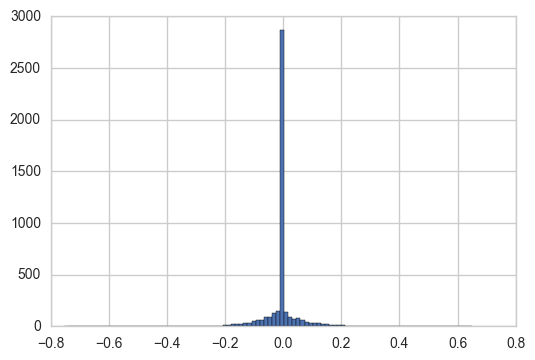

In [94]:
pd.Series(W.values.ravel()).hist(bins=100)

In [183]:
weight_cutoff = .1

In [189]:
W.head()

Drug      681640  AG014699   AP24534   AZD7762  BMS536924  BRYOSTATIN1  \
RPPA                                                                     
ABL1    0.052307  0.202778  0.000001  0.000006   0.000114     0.000022   
ACACA   0.000567 -0.000023  0.000019  0.076289   0.000033     0.002028   
ACVRL1  0.000053 -0.000014  0.000139  0.000227   0.000091     0.000023   
ADAR    0.043160  0.000003  0.000005  0.000014  -0.000013     0.000004   
AKT1    0.000002 -0.000023 -0.034954  0.000023  -0.000029    -0.000041   

Drug    CHIR99021  CISPLATIN   GEMCITABINE  GSK690693    ...     NUTLIN3A  \
RPPA                                                     ...                
ABL1     0.000038   0.000003  7.664552e-06  -0.000020    ...     0.032287   
ACACA    0.021991   0.000035  6.652804e-07  -0.009369    ...     0.000003   
ACVRL1   0.000012   0.000078  2.771789e-02  -0.000029    ...     0.000018   
ADAR     0.004382   0.130830 -1.381365e-01  -0.000022    ...    -0.108043   
AKT1    -0.000027   0.017782 -4.975505e-02  -0.000016    ...    -0.000066   

Drug        OLAPARIB  PD0325901  PD0332991   PLX4720      SB590885  THZ21021  \
RPPA                                                                           
ABL1    9.364549e-03   0.000014   0.154517  0.000029  1.780075e-05  0.000047   
ACACA  -5.472666e-03   0.129392  -0.048210 -0.000005 -1.221652e-05  0.000035   
ACVRL1  1.124482e-05  -0.000023   0.000024  0.059486  9.033835e-04 -0.020827   
ADAR   -1.524095e-07   0.000035   0.013912 -0.000005 -3.373943e-07  0.000010   
AKT1    3.151826e-02   0.000007  -0.000007  0.032185 -7.247442e-05 -0.000024   

Drug      XMD132     YM155  YM201636  
RPPA                                  
ABL1   -0.154568 -0.000020  0.028594  
ACACA  -0.000002  0.000006 -0.047491  
ACVRL1 -0.000007  0.000062 -0.000005  
ADAR   -0.047671 -0.020525 -0.000023  
AKT1   -0.063399 -0.000002 -0.041970  

[5 rows x 26 columns]

In [192]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)',
    width=1000, height=600
)
fig = W.applymap(lambda v: np.nan if abs(v) <= weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
filename = rpath('rppa_weight_all.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/rppa_weight_all.html


In [182]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)<br>* Highly predictable drugs only',
    width=1000, height=400
)
fig = W[top_drugs].applymap(lambda v: np.nan if abs(v) < weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
filename = rpath('rppa_weight_best.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/rppa_weight_best.html


In [124]:
top_drugs

Index(['AP24534', 'AZD7762', 'CHIR99021', 'CISPLATIN', 'GSK690693', 'OLAPARIB',
       'PD0325901', 'PLX4720', 'XMD132'],
      dtype='object', name='Task')

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/pred_top_drugs.png'

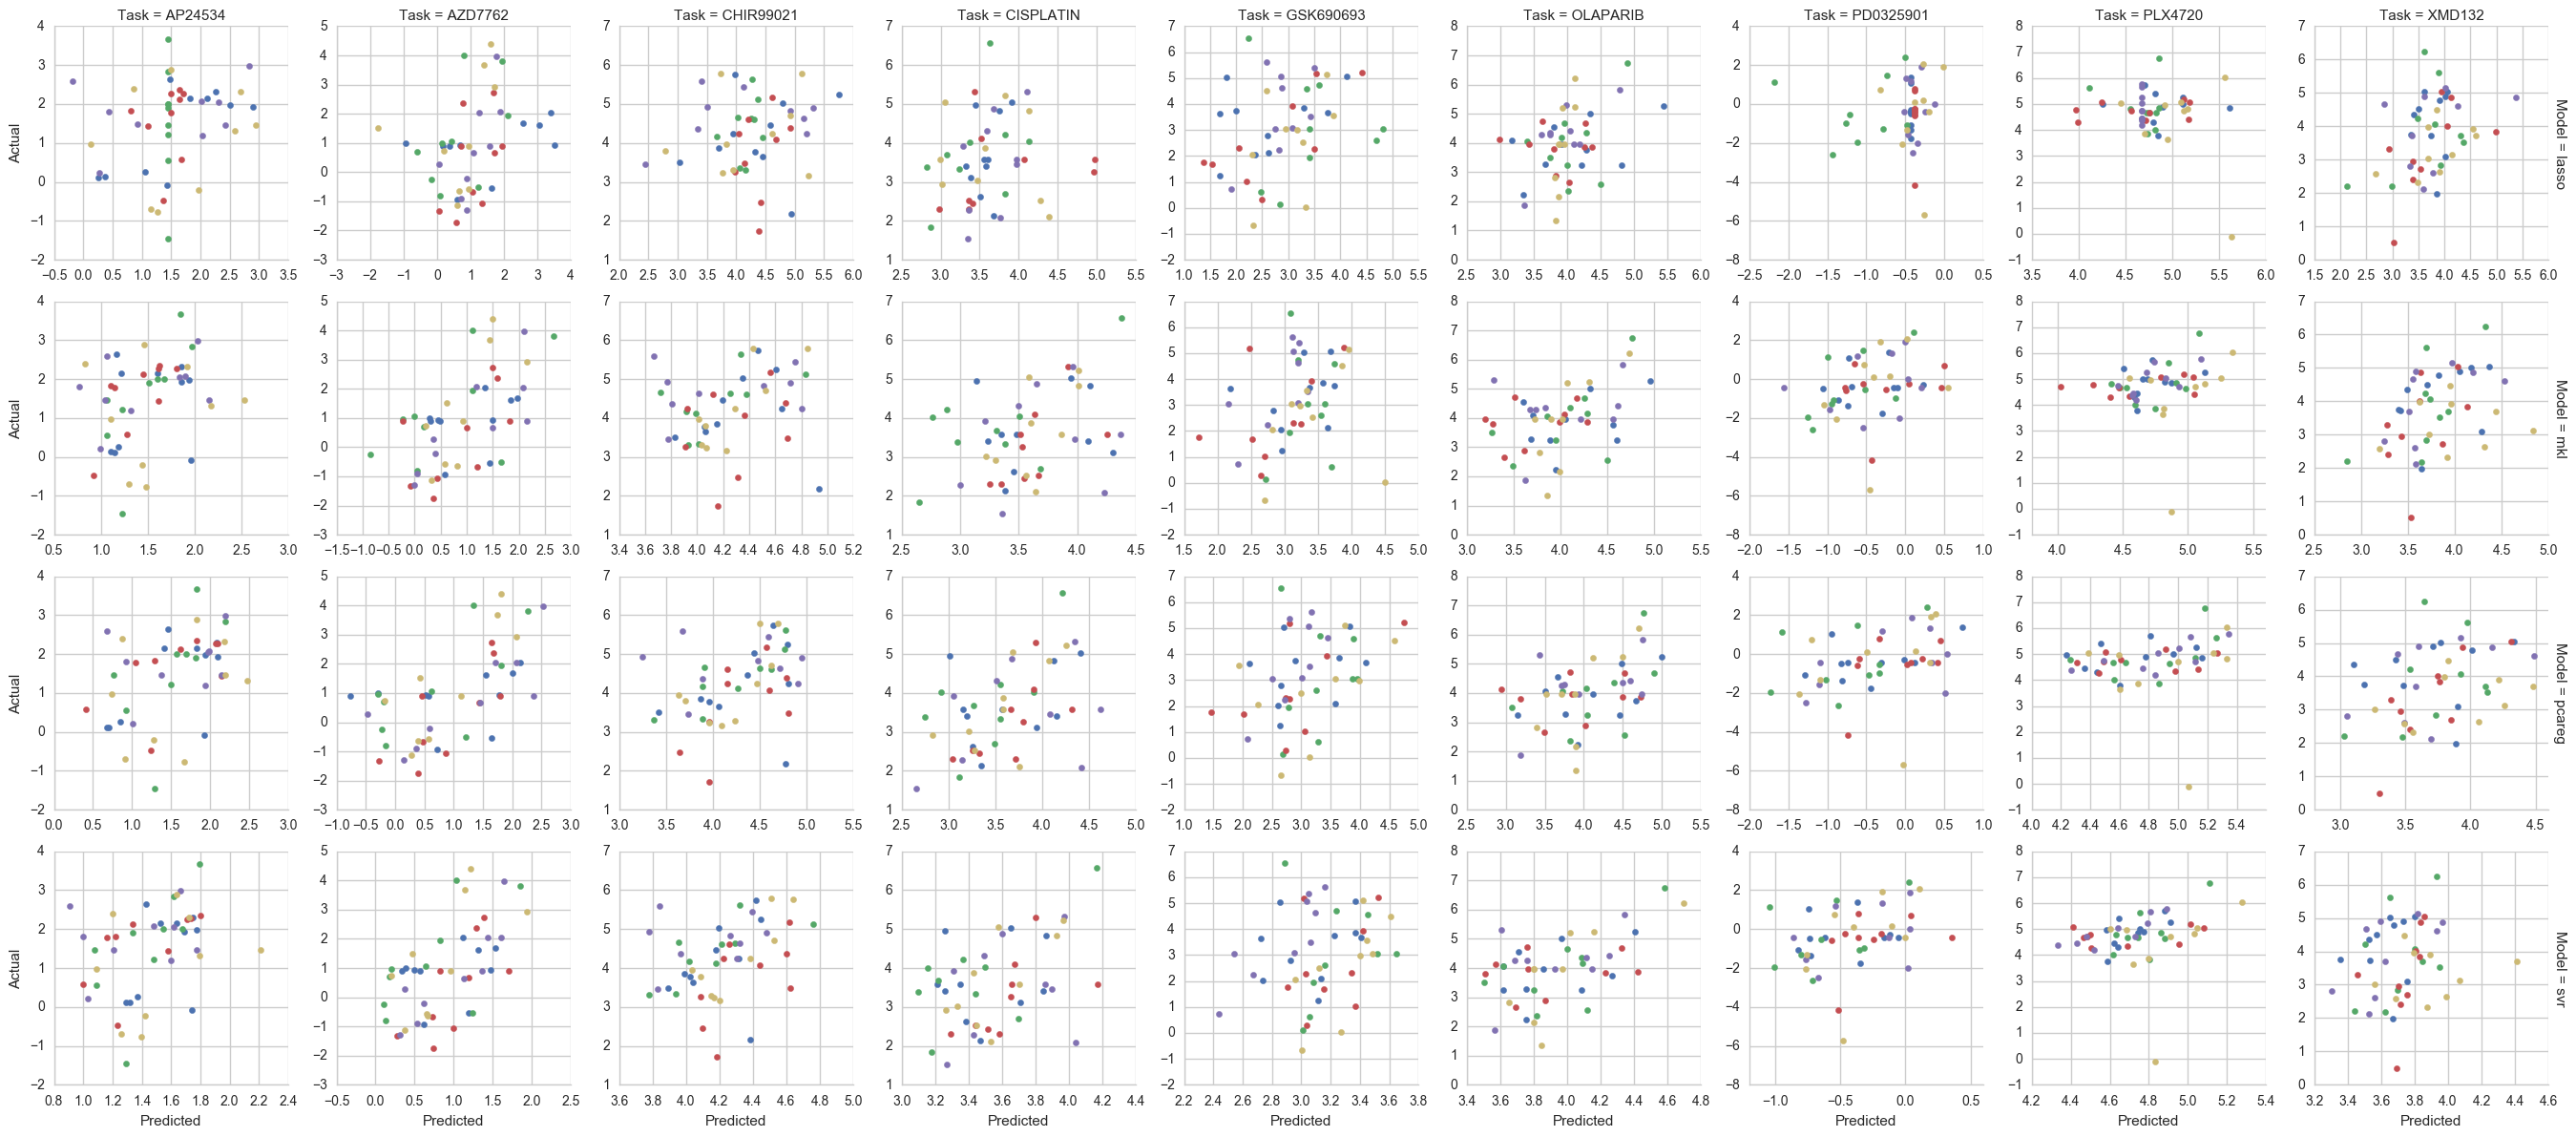

In [129]:
d_plt = d_pred_melt[d_pred_melt['Task'].isin(top_drugs)]
d_plt = d_plt[d_plt['Model'].isin(['lasso', 'svr', 'pcareg', 'mkl'])]
predictions.visualize(train_res, d_plt, share_axes=False, figsize=3)
filename = rpath('pred_top_drugs.png')
plt.savefig(filename)
filename

In [146]:
def plot_single_drug(d, drug, model):
    d = d[d['Task'] == drug]
    d = d[d['Model'] == model]
    trace = go.Scatter(
        x=d['Predicted'],
        y=d['Actual'],
        mode='markers',
        text=d.reset_index()['CELL_LINE_ID:MGDS']
    )
    layout = go.Layout(
        title='Predictions (Model = "{}", Drug = "{}")'.format(model, drug),
        hovermode='closest'
    )
    fig = go.Figure(data=[trace], layout=layout)
    filename = rpath('pred_best_{}_{}.html'.format(drug, model))
    plty.offline.plt(fig, filename=filename)
    print(filename)
    plty.offline.iplt(fig)

# plot_single_drug(d_pred_melt, 'AZD7762', 'mkl')
# plot_single_drug(d_pred_melt, 'AZD7762', 'svr')
# plot_single_drug(d_pred_melt, 'AZD7762', 'pcareg')
# plot_single_drug(d_pred_melt, 'PD0325901', 'mkl')
# plot_single_drug(d_pred_melt, 'PD0325901', 'svr')
plot_single_drug(d_pred_melt, 'PD0325901', 'pcareg')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/pred_best_PD0325901_pcareg.html


# KL Comparison to Other Methods

In [ ]:
def get_coef_array(multi_est):
    d_coef = []
    for est in multi_est.estimators_:
        d_coef.append(est.coef_)
    return pd.DataFrame(d_coef, index=Y_drug.columns, columns=X_drug.columns)

### Lasso

In [171]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['lasso']

d_coef = get_coef_array(est.clf.named_steps['est'])
d_coef.head()

A1BG  A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  AADAC  AADACL2  AADAT  \
Drug                                                                            
681640     -0.0 -0.0    0.0     0.0   -0.0   0.0  -0.0   -0.0      0.0   -0.0   
AG014699    0.0 -0.0    0.0    -0.0    0.0  -0.0  -0.0    0.0     -0.0   -0.0   
AP24534    -0.0  0.0   -0.0     0.0   -0.0  -0.0   0.0   -0.0      0.0   -0.0   
AZD7762     0.0 -0.0   -0.0     0.0    0.0  -0.0   0.0    0.0     -0.0   -0.0   
BMS536924   0.0  0.0   -0.0    -0.0    0.0  -0.0  -0.0   -0.0     -0.0   -0.0   

           ...   ZSWIM7  ZSWIM8  ZUFSP  ZWINT  ZXDC  ZYG11A  ZYG11B  ZYX  \
Drug       ...                                                             
681640     ...     -0.0     0.0   -0.0   -0.0   0.0     0.0    -0.0 -0.0   
AG014699   ...      0.0     0.0   -0.0   -0.0  -0.0     0.0    -0.0 -0.0   
AP24534    ...     -0.0     0.0   -0.0    0.0   0.0     0.0     0.0 -0.0   
AZD7762    ...     -0.0    -0.0   -0.0    0.0   0.0     0.0    -0.0 -0.0   
BMS536924  ...      0.0    -0.0   -0.0   -0.0  -0.0     0.0    -0.0  0.0   

           ZZEF1  ZZZ3  
Drug                    
681640      -0.0  -0.0  
AG014699    -0.0  -0.0  
AP24534     -0.0  -0.0  
AZD7762     -0.0  -0.0  
BMS536924    0.0  -0.0  

[5 rows x 13415 columns]

In [172]:
has_pos = d_coef.abs().sum(axis=0)
d_coef_top = d_coef[list(has_pos[has_pos > 0].index.values)]
print(d_coef_top.shape)
layout = dict(
    title='Lasso Coefficients on Most Predictable Drugs',
    margin=dict(l=100)
)
fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
plty.offline.iplt(fig)
filename = rpath('lasso_weight.html')
plty.offline.plt(fig, filename=filename)
print(filename)

(26, 498)


/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/lasso_weight.html


### Ridge

In [173]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['ridge']

d_coef = get_coef_array(est.clf.named_steps['est'])
d_coef.head()

A1BG       A2M     A2ML1    A4GALT         A4GNT      AAAS  \
Drug                                                                        
681640    -0.000277 -0.000323  0.000187  0.000087 -3.539409e-04  0.000072   
AG014699   0.000592 -0.000028  0.000016 -0.000304  4.159849e-04 -0.001076   
AP24534   -0.000145  0.000144 -0.000818  0.000082 -3.652510e-04 -0.000337   
AZD7762    0.000371 -0.000124 -0.000265  0.000050  1.561136e-04 -0.000355   
BMS536924  0.000061  0.000038 -0.000053 -0.000108  1.588634e-07 -0.000075   

                   AACS     AADAC   AADACL2     AADAT    ...       ZSWIM7  \
Drug                                                     ...                
681640    -2.614828e-04 -0.000383  0.000380 -0.000400    ...    -0.000334   
AG014699  -4.780450e-04 -0.000243  0.000142 -0.000379    ...    -0.000608   
AP24534   -3.141848e-04 -0.000507  0.000615 -0.000294    ...    -0.000257   
AZD7762    2.420914e-04  0.000229 -0.000187 -0.000162    ...    -0.000026   
BMS536924 -5.886306e-07 -0.000013  0.000002 -0.000043    ...     0.000021   

             ZSWIM8     ZUFSP     ZWINT      ZXDC    ZYG11A    ZYG11B  \
Drug                                                                    
681640     0.000418 -0.000220 -0.000320 -0.000043  0.000174 -0.000033   
AG014699   0.000223 -0.000056 -0.000408 -0.000392  0.001214 -0.000634   
AP24534    0.000121 -0.000105 -0.000047  0.000839  0.000518  0.000470   
AZD7762   -0.000384 -0.000060 -0.000096 -0.000137  0.000679 -0.000314   
BMS536924 -0.000047 -0.000052 -0.000077 -0.000050  0.000048 -0.000037   

                ZYX     ZZEF1      ZZZ3  
Drug                                     
681640    -0.000058 -0.000153 -0.000221  
AG014699   0.000288 -0.001163 -0.000531  
AP24534   -0.000041 -0.000524 -0.000315  
AZD7762   -0.000424 -0.000083 -0.000345  
BMS536924  0.000109 -0.000001 -0.000140  

[5 rows x 13415 columns]

In [174]:
mean_coef = d_coef.abs().mean(axis=0).sort_values(ascending=False)
d_coef_top = d_coef[list(mean_coef.head(500).index.values)]
layout = dict(
    title='Ridge Coefficients on Most Predictable Drugs',
    margin=dict(l=100)
)
fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
plty.offline.iplt(fig)
filename = rpath('ridge_weight.html')
plty.offline.plt(fig, filename=filename)
print(filename)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/ridge_weight.html


# Graveyard

In [175]:
#known_drugs = ['']
# W['NUTLIN3A'].abs().sort_values().tail(25)
# W['AG014699'].abs().sort_values().tail(25)
# W['PLX4720'].abs().sort_values().tail(25)
# W['SB590885'].abs().sort_values().tail(25)
#W['PD0332991'].abs().sort_values().tail(25)
#W['PLX4720'].abs().sort_values().tail(25)
